In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import pearsonr

from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error as mse 
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score as r2  

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import LeaveOneOut, cross_val_predict
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression, VarianceThreshold

%load_ext autoreload
%autoreload 2

### 1. Read wheat and weather data

In [3]:
wheat = pd.read_csv("data/crop/national_yield_with_trend.csv")
weather1 = pd.read_csv("data/hindcast_ba_era_features.csv")
weather2 = pd.read_csv("data/nmme_basic_quantile_era_features.csv")

weather = pd.concat([weather1, weather2], ignore_index=True).drop_duplicates().reset_index(drop=True)

x_y_cv = weather.merge(wheat[["year", "yield [kg/ha]"]], on="year")
x_y_cv = x_y_cv.loc[x_y_cv["year"] < 2017].reset_index(drop=True) # Leave test set aside

### 2. Detrend national wheat yield
.. using all previous years to estimate the slope (data since 69 is available)

#### 2.1 Estimate slope and bias for each year's trend correction

In [4]:
years_to_params = {}
for year in x_y_cv["year"].unique().tolist(): years_to_params[year] = {"slope":np.nan, "bias":np.nan}

for year in x_y_cv["year"].unique().tolist():
    year_range = wheat.loc[wheat["year"].isin(list(range(year-23, year))), ["year", "yield [kg/ha]"]]
    slope, bias= np.polyfit(year_range["year"], year_range["yield [kg/ha]"], deg=1)
    years_to_params[year]["slope"] = slope
    years_to_params[year]["bias"] = bias

years_to_params[2010]

{'slope': 39.78834453849199, 'bias': -77167.39684354172}

#### 2.2 Predict yield level for each year based on trend function

.. and visualize the trend estimates compared to observed yield

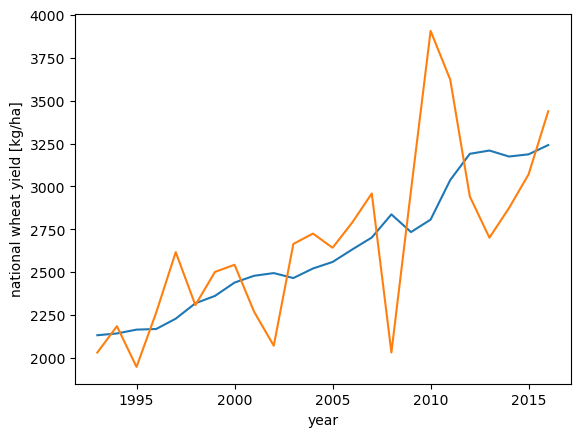

In [5]:
trend_estimated = []

for year in x_y_cv["year"].unique().tolist():
    value = year * years_to_params[year]["slope"] + years_to_params[year]["bias"]
    trend_estimated.append(value)
    
plt.plot(x_y_cv["year"].unique(), trend_estimated)
plt.plot(x_y_cv["year"].unique(), x_y_cv["yield [kg/ha]"].unique())
plt.ylabel("national wheat yield [kg/ha]")
plt.xlabel("year")

#print(np.round(mse(trend_estimated, x_y_cv["yield [kg/ha]"].values.tolist(), squared=False), 2))
plt.show()

#### 2.3. Adjust the trend using multiplicative decomposition

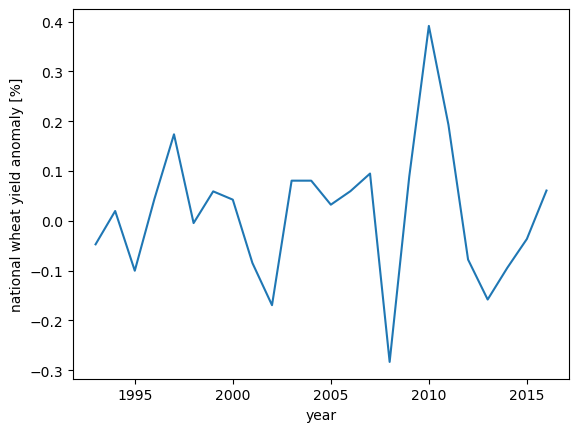

In [6]:
trend = pd.DataFrame(np.array([trend_estimated, list(range(1993,2017))]).transpose(), columns=["yield_trend [kg/ha]", "year"])
trend["year"] = trend["year"].astype(int)
x_y_cv = x_y_cv.merge(trend, on=["year"])
x_y_cv["yield anomaly [%]"] = (x_y_cv["yield [kg/ha]"] - x_y_cv["yield_trend [kg/ha]"])/x_y_cv["yield_trend [kg/ha]"]

plt.plot(x_y_cv["year"].unique(), x_y_cv["yield anomaly [%]"].unique());
plt.ylabel("national wheat yield anomaly [%]")
plt.xlabel("year")
plt.show()

### 3. Train model

#### 3.1 Expand features through basis functions

In [7]:
li = []
for model in ['BOM', 'CMCC', 'CWB', 'DWD', 'ECCC', 'ECMWF', 'ERA', 'JMA', 'KMA', 'METFR', 'PNU', 'UKMO', 'CCSM4', 'GFDL', 'NASA']:

    X = x_y_cv.loc[(x_y_cv["model"] == model), [c for c in x_y_cv.columns if ("rain" in c) or ("tmean" in c)]].reset_index(drop=True)
    y = x_y_cv.loc[(x_y_cv["model"] == model), [c for c in x_y_cv.columns if ("rain" not in c) and ("tmean" not in c)]].reset_index(drop=True)
    X_columns = X.columns

    # scale features
    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X), columns=X_columns)

    # store features and target in variables for better readability
    X_temp = X.loc[:, [c for c in X.columns if ("tmean" in c)]]
    X_rain = X.loc[:, [c for c in X.columns if ("rain" in c)]]

    # basis expansion to linear model
    X_tmean_squared = pd.DataFrame(np.array(np.multiply(X_temp, X_temp)), columns=["tt_8_a", "tt_9_a", "tt_10_a", "tt_11_a", "tt_8_b", "tt_9_b", "tt_10_b", "tt_11_b"])
    X_rain_squared = pd.DataFrame(np.array(np.multiply(X_rain, X_rain)), columns=["rr_8_a", "rr_9_a", "rr_10_a", "rr_11_a", "rr_8_b", "rr_9_b", "rr_10_b", "rr_11_b"])
    X_tmean_times_rain = pd.DataFrame(np.multiply(np.array(X_temp), np.array(X_rain)), columns=["rt_8_a", "rt_9_a", "rt_10_a", "rt_11_a", "rt_8_b", "rt_9_b", "rt_10_b", "rt_11_b"])

    # merge to feature dataframe
    X = (X.merge(X_tmean_squared.merge(X_rain_squared.merge(X_tmean_times_rain, left_index=True, right_index=True), left_index=True, right_index=True), left_index=True, right_index=True))

    df = pd.concat([y, X], axis=1)
    li.append(df)

x_y_cv_expanded = pd.concat(li, ignore_index=True)

#### 3.2 Drop correlated features

In [8]:
# remove correlated features
X = x_y_cv_expanded.loc[x_y_cv_expanded["model"] == "ERA", [c for c in x_y_cv_expanded.columns if c not in ['model', 'year', 'init_month', 'yield [kg/ha]', 'yield_trend [kg/ha]', 'yield anomaly [%]']]]
cor_matrix = X.corr().abs().round(2)
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.75)]
print(to_drop)

x_y_cv_expanded = x_y_cv_expanded.drop(to_drop, axis=1)
x_y_cv_expanded.head()

['rain_hipolito yrigoyen_8', 'tmean_hipolito yrigoyen_10', 'tmean_hipolito yrigoyen_11', 'tmean_hipolito yrigoyen_8', 'tmean_hipolito yrigoyen_9', 'tt_8_b', 'tt_9_b', 'tt_10_b', 'rr_10_a', 'rr_11_a', 'rr_10_b']


,model,year,init_month,yield [kg/ha],yield_trend [kg/ha],yield anomaly [%],rain_coronel dorrego_10,rain_coronel dorrego_11,rain_coronel dorrego_8,rain_coronel dorrego_9,...,rr_9_b,rr_11_b,rt_8_a,rt_9_a,rt_10_a,rt_11_a,rt_8_b,rt_9_b,rt_10_b,rt_11_b
0,BOM,1993,6,2032.688963,2133.53106,-0.047265,0.891471,0.313860,-0.925390,-0.401363,...,0.050717,0.282151,-1.886019,-0.399671,1.051405,0.678649,-0.106844,-0.302181,0.955700,1.030560
1,BOM,1993,7,2032.688963,2133.53106,-0.047265,-1.526182,0.313860,0.379090,-0.034653,...,5.590730,3.527911,3.006386,-0.407436,-0.487969,0.062339,1.676806,-3.815800,-0.727619,-4.184325
2,BOM,1993,8,2032.688963,2133.53106,-0.047265,1.664867,0.234503,-0.833968,-0.027875,...,0.028589,0.041203,-3.748717,-0.351418,1.863079,0.054833,-2.462309,0.242647,2.143888,-0.457274
3,BOM,1993,9,2032.688963,2133.53106,-0.047265,0.447506,0.575711,-1.010837,1.427826,...,0.050717,3.499092,-0.583109,-0.823323,-0.432770,-2.671498,-0.082777,-0.324798,0.092310,-3.980067
4,BOM,1993,10,2032.688963,2133.53106,-0.047265,0.310965,-0.170177,-1.010837,-1.006929,...,0.027472,0.216191,-0.487958,0.107907,-0.432770,-0.159540,0.681263,0.060946,0.092310,-0.572814


### 3.4 Train model

In [9]:
# K-Fold Cross Validation
def kfold_cross_validation(data, model="ECMWF", init=8, no_of_features=2):
    """Retrain, select features, and directly forecast yield on national level.
    
    params:
     - data: all features and yield on national level for all years
     - model: hindcast model to validate (default: ECMWF)
     - init: month of model initialization to validate (default:8)
     - no_of_features: the number of most correlated features with the target to be selected
     
    returns:
     - national_forecasts_by_year: dataframe with forecasted and observed national wheat yield for the selected model and month of initialization on cross validation
    """
    # Filter by model and init_month but also include observations that are used for model training
    if init == 12: model = "ERA"
    cv_dataset = (data.loc[((data["model"] == model) & (data["init_month"] == init))
                               | ((data["model"] == "ERA") & (data["init_month"] == 12))])
    # Dataframe where interim results are saved
    national_forecasts_by_year = (pd.DataFrame(data={"year":list(range(1993,2017)), "predicted":np.zeros(24)})
                                  .merge(cv_dataset.loc[(cv_dataset["model"] == "ERA"), 
                                                        ["year", "yield anomaly [%]"]], on="year", how="left"))
    # Features
    relevant_columns = [c for c in cv_dataset.columns if c not in ["model", "init_month", "year", "yield [kg/ha]", "yield_trend [kg/ha]", "yield anomaly [%]"]]
    
    for season in list(range(1993,2017)):
        X_train = cv_dataset.loc[((cv_dataset["model"] == "ERA") & (cv_dataset["year"] != season))
                                 | (() & ()), relevant_columns].reset_index(drop=True)
        y_train = cv_dataset.loc[(cv_dataset["model"] == "ERA") 
                                 & (cv_dataset["year"] != season), "yield anomaly [%]"].reset_index(drop=True)
        
        #print(season)
        #print(X_train)    
        pipeline = Pipeline([('scaler', StandardScaler()), 
                             ('var', VarianceThreshold()), 
                             ('selector', SelectKBest(f_regression, k=no_of_features)),
                             ('estimator', Ridge())])
        
        reg = pipeline.fit(X_train, y_train)  
        
        coefficients = reg["estimator"].coef_
        bias = reg["estimator"].intercept_
        features = reg["selector"].get_feature_names_out(relevant_columns)
        #print(features)
        X_val = cv_dataset.loc[(cv_dataset["model"] == model)
                               & (cv_dataset["year"] == season), relevant_columns].reset_index(drop=True)
        
        y_predicted = reg.predict(X_val)[0]
            
        # each forecast is weighted by the group's relative contribution to national harvested area
        national_forecasts_by_year.loc[national_forecasts_by_year["year"] == season, "predicted"] = y_predicted
    
    return national_forecasts_by_year

In [10]:
x_y_cv_expanded["model"].unique()

array(['BOM', 'CMCC', 'CWB', 'DWD', 'ECCC', 'ECMWF', 'ERA', 'JMA', 'KMA',
       'METFR', 'PNU', 'UKMO', 'CCSM4', 'GFDL', 'NASA'], dtype=object)

In [11]:
models = ['BOM', 'CMCC', 'CWB', 'DWD', 'ECCC', 'ECMWF', 'ERA', 'JMA', 'KMA', 'METFR', 'PNU', 'UKMO', 'CCSM4', 'GFDL', 'NASA']
results = pd.DataFrame(0, index=models, columns=[6, 7, 8, 9, 10, 11])
for im in [6, 7, 8, 9, 10, 11]:
    for model in models:
        res = kfold_cross_validation(x_y_cv_expanded, model=model, init=im, no_of_features=2)
        # rmse
        #metric = 100 * mse(res["yield anomaly [%]"], res["predicted"], squared=False)
        # mae
        #metric = np.round(mae(res["predicted"], res["yield anomaly [%]"]), 4)
        # r
        #metric = np.round(pearsonr(res["predicted"], res["yield anomaly [%]"])[0], 2)
        
        # coefficient of determination
        metric = r2(res["yield anomaly [%]"], res["predicted"])
        
        results.loc[model, im] = np.round(metric, 2)

results

,6,7,8,9,10,11
BOM,0.06,-0.72,-0.78,-0.50,0.05,-0.02
CMCC,-1.08,-0.25,-0.41,-0.50,-0.58,0.23
CWB,-0.80,-0.44,-0.25,-0.48,0.09,0.07
DWD,-1.21,-0.71,-0.85,-1.07,-0.12,0.16
ECCC,-0.62,-0.53,-1.07,-1.67,-0.01,0.24
ECMWF,-1.49,-0.67,-0.30,-0.80,-0.43,-0.15
ERA,0.53,0.53,0.53,0.53,0.53,0.53
JMA,-0.61,-0.30,-1.31,-0.31,-0.07,-0.04
KMA,-1.28,-1.42,-1.27,-0.94,0.23,0.34
METFR,-0.66,-0.79,-0.66,-0.91,-0.25,0.13


#### 3.5 MME

In [12]:
df_lean = x_y_cv_expanded.loc[(x_y_cv_expanded["init_month"] == 10) & (x_y_cv_expanded["model"] != "ERA"), ['model', 'year', 'init_month', 'rr_11_b', 'rt_9_a']].reset_index(drop=True)
df_lean_era = x_y_cv_expanded.loc[(x_y_cv_expanded["init_month"] == 12) & (x_y_cv_expanded["model"] == "ERA"), ['model', 'year', 'init_month', 'rr_11_b', 'rt_9_a']].reset_index(drop=True)

model_to_error = {}

for model in ['BOM', 'CMCC', 'CWB', 'DWD', 'ECCC', 'ECMWF', 'JMA', 'KMA', 'METFR', 'PNU', 'UKMO', 'CCSM4', 'GFDL', 'NASA']:
    bias = np.array(df_lean.loc[df_lean["model"] == model, ['rr_11_b', 'rt_9_a']]) -  np.array(df_lean_era.loc[df_lean_era["model"] == "ERA", ['rr_11_b', 'rt_9_a']])
    model_to_error[model] = bias

for model1 in ['BOM', 'CMCC', 'CWB', 'DWD', 'ECCC', 'ECMWF', 'JMA', 'KMA', 'METFR', 'PNU', 'UKMO', 'CCSM4', 'GFDL', 'NASA']:
    for model2 in ['BOM', 'CMCC', 'CWB', 'DWD', 'ECCC', 'ECMWF', 'JMA', 'KMA', 'METFR', 'PNU', 'UKMO', 'CCSM4', 'GFDL', 'NASA']:
        r = pearsonr(np.array(model_to_error[model1]).reshape(-1,1).flatten(), 
                     np.array(model_to_error[model2]).reshape(-1,1).flatten())[0]
        if r < 0.3:
            print("model1 {} with model2 {} has r of {}".format(model1, model2, r))

model1 BOM with model2 NASA has r of 0.14712563113513719
model1 CWB with model2 JMA has r of 0.2752044593920106
model1 ECMWF with model2 GFDL has r of 0.26627794837438046
model1 JMA with model2 CWB has r of 0.2752044593920106
model1 PNU with model2 GFDL has r of 0.25909502571279897
model1 GFDL with model2 ECMWF has r of 0.26627794837438046
model1 GFDL with model2 PNU has r of 0.25909502571279897
model1 NASA with model2 BOM has r of 0.14712563113513719


In [13]:
mme1 = x_y_cv_expanded.loc[x_y_cv_expanded["model"].isin(["BOM", "CWB", "KMA", "GFDL", "NASA"])].assign(model="MME_BEST_OCT").groupby(["model", "year", "init_month"]).mean().reset_index()
mme2 = x_y_cv_expanded.loc[x_y_cv_expanded["model"].isin(['CMCC', 'CWB', 'DWD', 'ECCC', 'KMA', 'METFR', 'UKMO', 'CCSM4', 'GFDL', 'NASA'])].assign(model="MME_BEST_NOV").groupby(["model", "year", "init_month"]).mean().reset_index()
mme3 = x_y_cv_expanded.loc[x_y_cv_expanded["model"].isin(["BOM", "NASA"])].assign(model="MME_UC1").groupby(["model", "year", "init_month"]).mean().reset_index()
mme4 = x_y_cv_expanded.loc[x_y_cv_expanded["model"].isin(["JMA", "CWB"])].assign(model="MME_UC2").groupby(["model", "year", "init_month"]).mean().reset_index()
mme5 = x_y_cv_expanded.loc[x_y_cv_expanded["model"] != "ERA"].assign(model="MME_ALL").groupby(["model", "year", "init_month"]).mean().reset_index()

x_y_cv_expanded = pd.concat([mme1, mme2, mme3, mme4, mme5, x_y_cv_expanded], ignore_index=True)

In [14]:
x_y_cv_expanded["model"].unique()

array(['MME_BEST_OCT', 'MME_BEST_NOV', 'MME_UC1', 'MME_UC2', 'MME_ALL',
       'BOM', 'CMCC', 'CWB', 'DWD', 'ECCC', 'ECMWF', 'ERA', 'JMA', 'KMA',
       'METFR', 'PNU', 'UKMO', 'CCSM4', 'GFDL', 'NASA'], dtype=object)

In [27]:
models = ['ERA', 'KMA']
results = pd.DataFrame(0, index=models, columns=[6, 7, 8, 9, 10, 11])
for im in [6, 7, 8, 9, 10, 11]:
    for model in models:
        res = kfold_cross_validation(x_y_cv_expanded, model=model, init=im, no_of_features=2)
        # rmse
        #metric = 100 * mse(res["yield anomaly [%]"], res["predicted"], squared=False)
        # mae
        #metric = np.round(mae(res["predicted"], res["yield anomaly [%]"]), 4)
        # r
        #metric = np.round(pearsonr(res["predicted"], res["yield anomaly [%]"])[0], 2)
        # coefficient of determination
        metric = r2(res["yield anomaly [%]"], res["predicted"])
        
        results.loc[model, im] = np.round(metric, 2)

results

,6,7,8,9,10,11
ERA,0.53,0.53,0.53,0.53,0.53,0.53
KMA,-1.28,-1.42,-1.27,-0.94,0.23,0.34


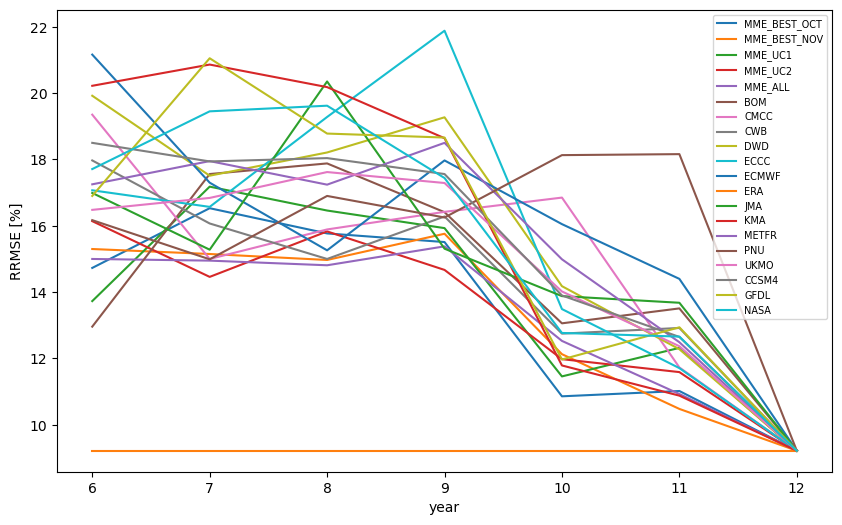

In [23]:
plt.rcParams["figure.figsize"] = (10,6)
results.transpose().plot()
plt.ylabel("RRMSE [%]")
plt.xlabel("year")
plt.legend(fontsize=7)
#plt.savefig("rrmse.svg")
plt.show()